In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import jax
import optax
from tqdm import tqdm
from IPython.display import clear_output
import dynamiqs as dq
import matplotlib.colors as clrs

# Utils

In [3]:
red, blue = plt.cm.Reds, plt.cm.Blues
fading_red, fading_blue = red(jnp.arange(red.N)), blue(jnp.arange(blue.N))
fading_red[:, -1], fading_blue[:, -1] = jnp.linspace(0., 1., red.N), jnp.linspace(0, 1., blue.N)
fading_red, fading_blue = clrs.ListedColormap(fading_red), clrs.ListedColormap(fading_blue)

2024-06-09 12:22:08.352383: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
@jax.jit
def compute_weights(abs_weights, phase_weights):
    weights = abs_weights*jnp.exp(1j*phase_weights)
    weights = weights/jnp.sqrt(jnp.abs(weights.T@weights))
    return weights

In [5]:
@jax.jit
def weight_points(weights, datas):
    return jnp.einsum('ijk, k -> ij', datas, weights)

In [6]:
@jax.jit
def compute_h_sampling(points):
    iqr_real = jnp.diff(jnp.percentile(points.real, jnp.array([25 ,75])))[0]
    iqr_imag = jnp.diff(jnp.percentile(points.imag, jnp.array([25 ,75])))[0]
    h_real = 2*iqr_real*(len(points)**(-1/3))
    h_imag = 2*iqr_imag*(len(points)**(-1/3))
    return h_real + 1j*h_imag

In [7]:
def compute_histogram(points):
    h = compute_h_sampling(points)
    
    vmin, vmax = jnp.min(points.real), jnp.max(points.real)
    bins_I = jnp.arange(vmin, vmax, h.real)
    
    vmin, vmax = jnp.min(points.imag), jnp.max(points.imag)
    bins_Q = jnp.arange(vmin, vmax, h.imag)

    hist_p, _, _ = jnp.histogram2d(points[:, 0].real, points[:, 0].imag, bins=(bins_I, bins_Q))
    hist_m, _, _ = jnp.histogram2d(points[:, 1].real, points[:, 1].imag, bins=(bins_I, bins_Q))
    return hist_p, hist_m, bins_I, bins_Q

In [8]:
def plot_hists(weights, points, axs=None):
    weighted_trajs = weight_points(weights, points)

    if axs is None:
        fig, axs_plt = plt.subplots(2, 2)
        axs_plt = axs_plt.flatten()
    else:
        axs_plt = axs
    
    hist_p, hist_m, bins_I, bins_Q = compute_histogram(weighted_trajs)
    center_I = (bins_I[1:] + bins_I[:-1])/2
    center_Q = (bins_Q[1:] + bins_Q[:-1])/2    
    
    axs_plt[2].pcolorfast(bins_I, bins_Q, hist_p.T, cmap=fading_blue)
    axs_plt[2].pcolorfast(bins_I, bins_Q, hist_m.T, cmap=fading_red)
    axs_plt[2].set_xlabel(r"$I$")
    axs_plt[2].set_xlabel(r"$Q$")
    
    axs_plt[0].bar(center_I, hist_p.sum(axis=1), bins_I[1] - bins_I[0], alpha=0.5, color='blue')
    axs_plt[0].bar(center_I, hist_m.sum(axis=1), bins_I[1] - bins_I[0], alpha=0.5, color='red')
    
    axs_plt[3].barh(center_Q, hist_p.sum(axis=0), bins_Q[1] - bins_Q[0], alpha=0.5, color='blue')
    axs_plt[3].barh(center_Q, hist_m.sum(axis=0), bins_Q[1] - bins_Q[0], alpha=0.5, color='red')
    
    axs_plt[1].plot(time, weights.real, label=r'$\mathcal{Re}$')
    axs_plt[1].plot(time, weights.imag, label=r'$\mathcal{Im}$')
    axs_plt[1].legend()
    axs_plt[1].set_xlabel('Time [µs]')
    axs_plt[1].set_title("Weights")

    for ax in axs_plt:
        ax.grid()

    if axs is None:
        fig.tight_layout()
        plt.show()

In [9]:
@jax.jit
def gaussian(center, width, x):
    return jnp.exp(-((x-center)/width)**2)

In [10]:
def wrap_opti(distance):
    def to_opt(params, points):
        abs_weights, phase_weights = params["abs_weights"], params["phase_weights"]
        w = compute_weights(abs_weights, phase_weights)
        weighted = weight_points(w, points)
        return distance(weighted)
    return to_opt

In [11]:
def compute_overlap(points) -> float:
    points = points.real
    h = compute_h_sampling(points).real
    vmin, vmax = jnp.min(points), jnp.max(points)
    xs = jnp.linspace(vmin, vmax, int((vmax-vmin)/h))
    hist = jnp.sum(gaussian(points[:, :, None], h, xs[None, None, :]), axis=0)
    hist = hist/jnp.sum(hist, axis=1)[:, None]
    return jnp.sum(jnp.minimum(hist[0], hist[1]))

In [12]:
@jax.jit
def minus_earth_mover_distance(points):
    u_values, v_values = points.real.T
    #u_values = jnp.concatenate((points[:, 0].real, points[:, 0].imag)).reshape(2, -1).T
    #v_values = jnp.concatenate((points[:, 1].real, points[:, 1].imag)).reshape(2, -1).T
    u_sorter = jnp.argsort(u_values)
    v_sorter = jnp.argsort(v_values)

    all_values = jnp.concatenate((u_values, v_values))
    all_values = all_values.sort()

    deltas = jnp.diff(all_values)

    u_cdf_indices = u_values[u_sorter].searchsorted(all_values[:-1], 'right')
    v_cdf_indices = v_values[v_sorter].searchsorted(all_values[:-1], 'right')

    u_cdf = u_cdf_indices / u_values.size
    v_cdf = v_cdf_indices / v_values.size

    return -jnp.sum(jnp.multiply(jnp.abs(u_cdf - v_cdf), deltas))

# Testing on synthetic data

## Mesolve

In [2]:
MHz = 2*jnp.pi
us = 1
ns = 1e-3

In [3]:
Na, Nb = 25, 15
n_inf = 4
g2 = 2*MHz
kappa_b = 10*MHz
period_drive = 200*ns

tmax= 1*us
n_t = 201

In [4]:
eps_d = -n_inf*g2
time = jnp.linspace(0, tmax, n_t)

a, b = dq.destroy(Na, Nb)
H = g2*a@a@dq.dag(b)
H += dq.dag(H)
H += dq.pwc(time, jnp.cos(2*jnp.pi*time[:-1]/period_drive + jnp.pi)*eps_d, b+dq.dag(b))
c_ops = [jnp.sqrt(kappa_b)*b]

alpha_p, alpha_m = dq.coherent(Na, jnp.sqrt(n_inf)), dq.coherent(Na, -jnp.sqrt(n_inf))
cat_p, cat_m = dq.unit(alpha_p + alpha_m), dq.unit(alpha_p - alpha_m)
rho_0 = [dq.tensor(cat, dq.fock(Nb, 0)) for cat in [cat_p, cat_m]]

output = dq.mesolve(H, c_ops, rho_0, time)

2024-06-11 14:58:40.405772: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
|███████████████████████████████████████████████████████████| 100.0% ◆ total 1.80s ◆ remaining 00:00


100%|███████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.96it/s]


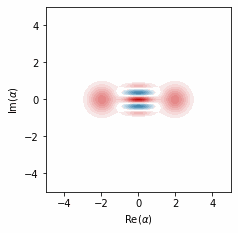

In [5]:
dq.plot_wigner_gif(dq.ptrace(output.states[0], 0, (Na, Nb)))

100%|███████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.47it/s]


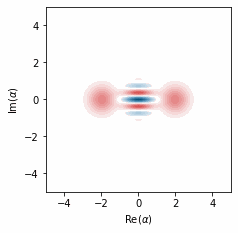

In [6]:
dq.plot_wigner_gif(dq.ptrace(output.states[1], 0, (Na, Nb)))

100%|███████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.40it/s]


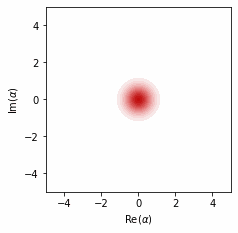

In [7]:
dq.plot_wigner_gif(dq.ptrace(output.states[0], 1, (Na, Nb)))

100%|███████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.24it/s]


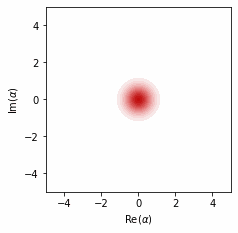

In [8]:
dq.plot_wigner_gif(dq.ptrace(output.states[1], 1, (Na, Nb)))

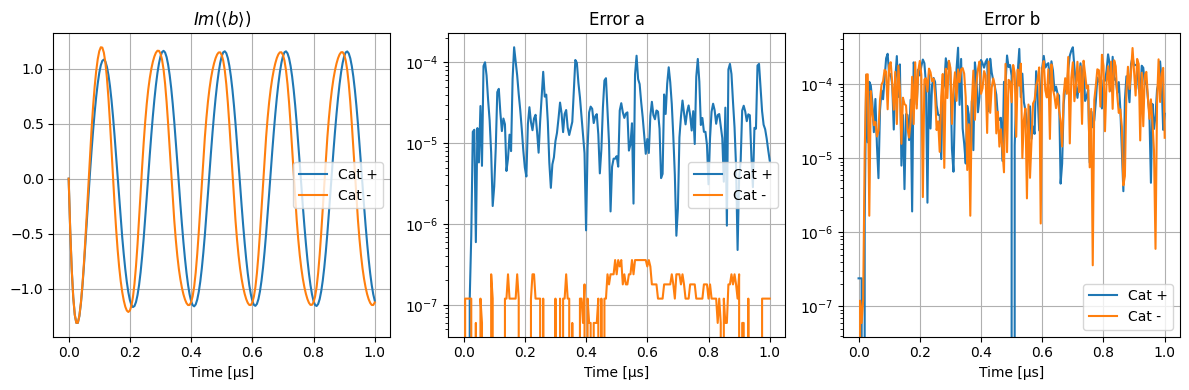

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(time, dq.expect(b, output.states).imag.T, label=['Cat +', 'Cat -'])
ax[1].plot(time, jnp.abs(dq.expect(a@dq.dag(a) - dq.dag(a)@a, output.states)-1).T, label=['Cat +', 'Cat -'])
ax[1].set_yscale('log')
ax[2].plot(time, jnp.abs(dq.expect(b@dq.dag(b) - dq.dag(b)@b, output.states)-1).T, label=['Cat +', 'Cat -'])
ax[2].set_yscale('log')

for sa, title in zip(ax.flatten(), [r'$Im(\langle b \rangle)$', 'Error a', 'Error b']):
    sa.set_title(title)
    sa.grid()
    sa.legend()
    sa.set_xlabel('Time [µs]')
fig.tight_layout()
plt.show()

### Testing with gaussian noise

In [55]:
n_traj = 20_000
sigma = 2
key_0 = jax.random.key(0)
key_1 = jax.random.key(1)

traj = dq.expect(b, output.states)
traj_noise = traj[None, :, :] + jax.random.normal(key_0, (n_traj, 2, n_t))*sigma
traj_noise += 1j*jax.random.normal(key_1, (n_traj, 2, n_t))*sigma

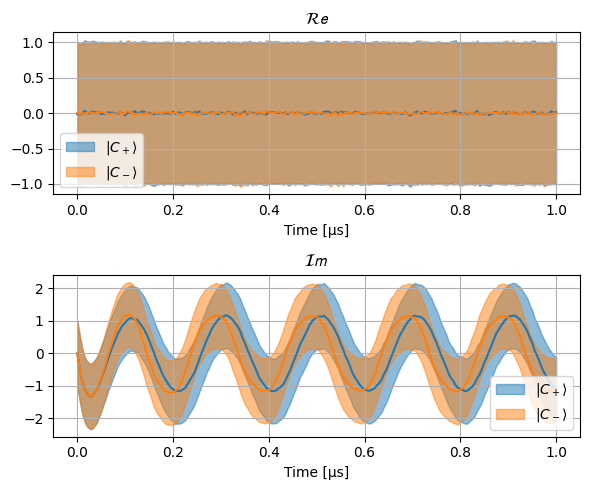

In [56]:
fig, ax = plt.subplots(2, figsize=(6, 5))
means, stds = jnp.mean(traj_noise, axis=0), jnp.std(traj_noise.real, axis=0) + 1j*jnp.std(traj_noise.imag, axis=0)
for ind_plot, (func, title) in enumerate(zip([jnp.real, jnp.imag], [r'$\mathcal{Re}$', r'$\mathcal{Im}$'])): 
    ax[ind_plot].plot(time, func(means).T)
    for ind, label in enumerate([r'$|C_+\rangle$', r'$|C_-\rangle$']):
        ax[ind_plot].fill_between(time, func(means[ind]) - func(stds[ind])/2, func(means[ind]) + func(stds[ind])/2, color=f'C{ind}', alpha=0.5, label=label)
    ax[ind_plot].grid()
    ax[ind_plot].legend()
    ax[ind_plot].set_xlabel('Time [µs]')
    ax[ind_plot].set_title(title)
fig.tight_layout()
plt.show()

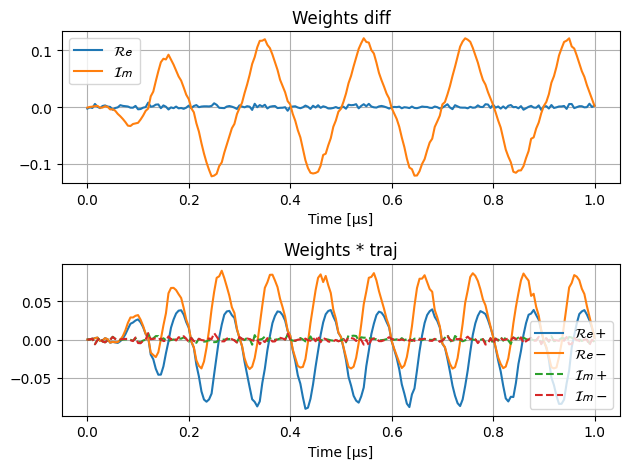

In [57]:
weights_diff = (means[0]-means[1])
# weights_diff = (traj[1]-traj[0])
weights_diff = weights_diff/jnp.sqrt(jnp.abs(weights_diff.T@weights_diff))
fig, (ax, ax1) = plt.subplots(2)
ax.plot(time, weights_diff.real, label=r'$\mathcal{Re}$')
ax.plot(time, weights_diff.imag, label=r'$\mathcal{Im}$')
ax.legend()
ax.set_xlabel('Time [µs]')
ax.set_title("Weights diff")
ax.grid()

ax1.plot(time, (weights_diff*means[0]).real, label=r'$\mathcal{Re} +$')
ax1.plot(time, (weights_diff*means[1]).real, label=r'$\mathcal{Re} -$')
ax1.plot(time, (weights_diff*means[0]).imag, '--', label=r'$\mathcal{Im} +$')
ax1.plot(time, (weights_diff*means[1]).imag, '--', label=r'$\mathcal{Im} -$')
ax1.legend()
ax1.set_xlabel('Time [µs]')
ax1.set_title("Weights * traj")
ax1.grid()

fig.tight_layout()
plt.show()

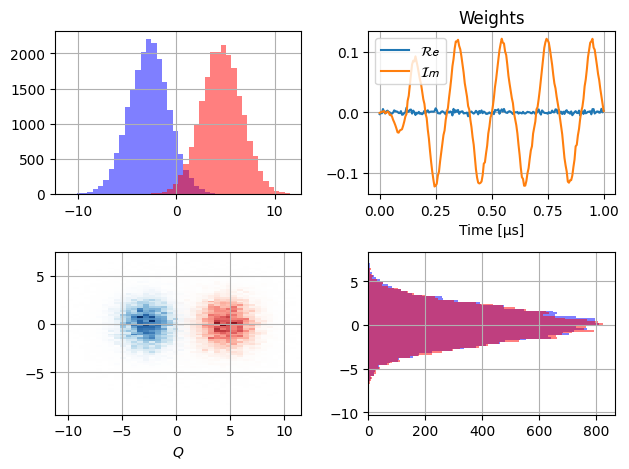

In [58]:
plot_hists(weights_diff, traj_noise)

### Optimization on overlap

In [34]:
#guess = weights_diff
guess = jax.random.normal(jax.random.key(2), (len(weights_diff),)) + 1j*jax.random.normal(jax.random.key(3), (len(weights_diff),))

params = {"abs_weights": jnp.abs(guess), "phase_weights": jnp.angle(guess)}
datas = traj_noise
wrap_opti(compute_overlap)(params, datas)

Array(0.82828397, dtype=float32)

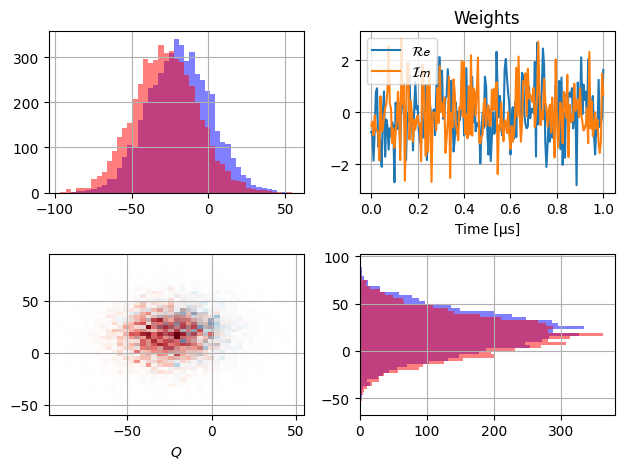

In [35]:
plot_hists(guess, datas)

In [36]:
N_optimize = 1000

optimizer = optax.adam(1e-1)
optimizer_state = optimizer.init(params)
costs = []

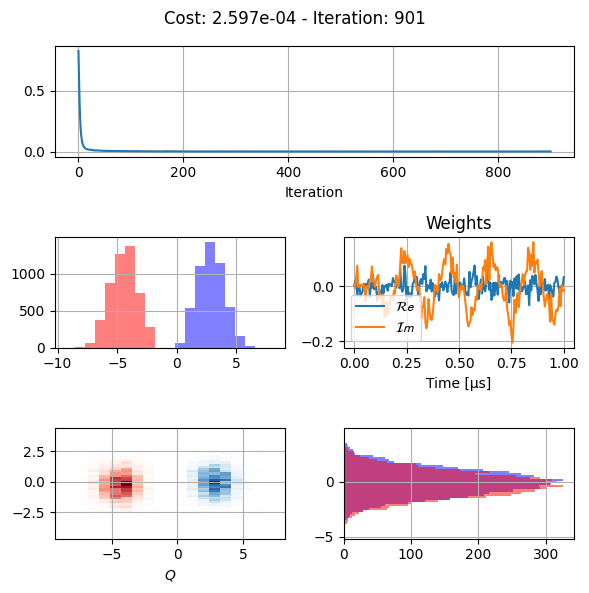

100%|███████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.84it/s]


In [37]:
for ind in tqdm(range(N_optimize)):
    cost, cost_grad = jax.value_and_grad(wrap_opti(compute_overlap), argnums = 0)(params, datas)
    updates, optimizer_state = optimizer.update(cost_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    costs.append(cost)

    if ind%100 == 0:
        clear_output(wait=True)
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(311)
        fig.suptitle(f'Cost: {cost:.3e} - Iteration: {ind+1}')
        ax.plot(costs)
        ax.set_xlabel("Iteration")
        ax.grid()
        axs = [fig.add_subplot(323 + i) for i in range(4)]
        weights = compute_weights(**params)
        plot_hists(weights, datas, axs)
        fig.tight_layout()
        plt.show()

### Optimization on earth mover distance

In [80]:
#guess = weights_diff
guess = jax.random.normal(jax.random.key(2), (len(weights_diff),)) + 1j*jax.random.normal(jax.random.key(3), (len(weights_diff),))

params = {"abs_weights": jnp.abs(guess), "phase_weights": jnp.angle(guess)}
datas = traj_noise
wrap_opti(minus_earth_mover_distance)(params, datas)

Array(-1.5376644, dtype=float32)

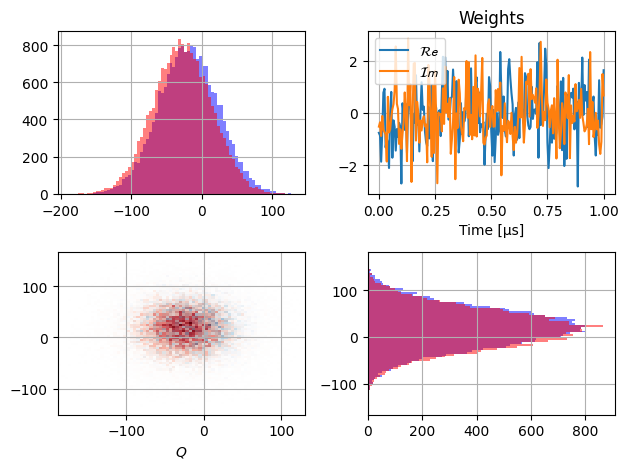

In [81]:
plot_hists(guess, datas)

In [82]:
N_optimize = 5000

optimizer = optax.adam(1e-4)
optimizer_state = optimizer.init(params)
costs = []

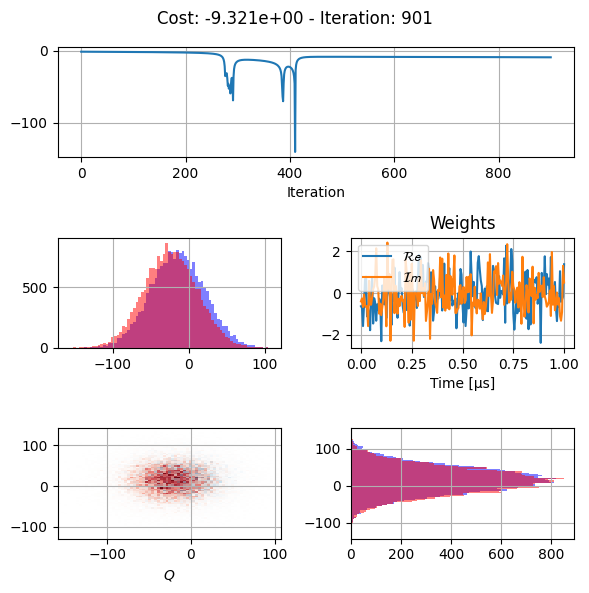

 19%|███████████                                                 | 927/5000 [01:53<08:17,  8.19it/s]


KeyboardInterrupt: 

In [83]:
for ind in tqdm(range(N_optimize)):
    cost, cost_grad = jax.value_and_grad(wrap_opti(minus_earth_mover_distance), argnums = 0)(params, datas)
    updates, optimizer_state = optimizer.update(cost_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    costs.append(cost)

    if ind%100 == 0:
        clear_output(wait=True)
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(311)
        fig.suptitle(f'Cost: {cost:.3e} - Iteration: {ind+1}')
        ax.plot(costs)
        ax.set_xlabel("Iteration")
        ax.grid()
        axs = [fig.add_subplot(323 + i) for i in range(4)]
        weights = compute_weights(**params)
        plot_hists(weights, datas, axs)
        fig.tight_layout()
        plt.show()

# Testing on real data

In [9]:
datas = jnp.load('/home/rroussea/Quantum_simulations/Optimal_demodulation_weights/data_for_weights_optimization.npy')[:, :, :-1]

In [11]:
datas.shape

(20000, 2, 249)

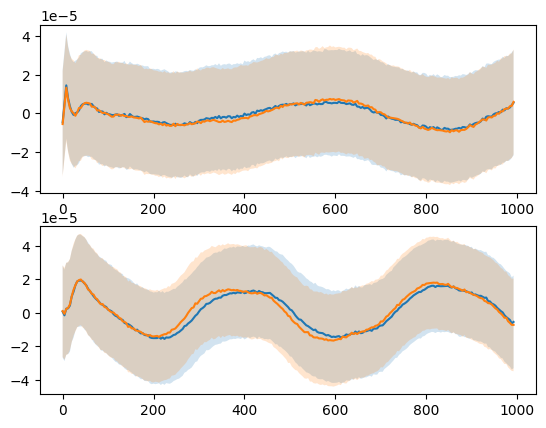

In [14]:
means = datas.mean(axis=0)
stds = datas.real.std(axis=0) + 1j*datas.imag.std(axis=0)

times = jnp.arange(datas.shape[-1])*4
fig, ax = plt.subplots(2)
ax[0].plot(times, means.real.T)
ax[0].fill_between(times, means[0].real.T-stds[0].real.T/2, means[0].real.T+stds[0].real.T/2, alpha=0.2)
ax[0].fill_between(times, means[1].real.T-stds[1].real.T/2, means[1].real.T+stds[1].real.T/2, alpha=0.2)
ax[1].plot(times, means.imag.T)
ax[1].fill_between(times, means[0].imag.T-stds[0].imag.T/2, means[0].imag.T+stds[0].imag.T/2, alpha=0.2)
ax[1].fill_between(times, means[1].imag.T-stds[1].imag.T/2, means[1].imag.T+stds[1].imag.T/2, alpha=0.2)
plt.show()

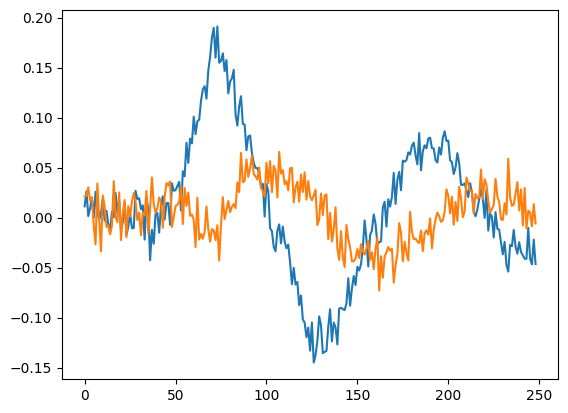

In [15]:
weights_diff = (means[0]-means[1])
weights_diff = weights_diff/jnp.sqrt(weights_diff.T@weights_diff)
plt.plot(weights_diff.real)
plt.plot(weights_diff.imag)

## Optimize on overlap

In [216]:
@jax.jit
def compute_weights(abs_weights, phase_weights):
    weights = abs_weights*jnp.exp(1j*phase_weights)
    weights = weights/jnp.sqrt(jnp.abs(weights.T@weights))
    return weights

In [217]:
@jax.jit
def weight_points(weights, datas):
    return jnp.einsum('ijk, k -> ij', datas, weights)

In [229]:
def plot_hist(ax, abs_weights, phase_weights):
    w = abs_weights*jnp.exp(1j*phase_weights)
    weighted = weight_points(w, datas).real
    vmin, vmax = jnp.min(weighted), jnp.max(weighted)
    xs = jnp.linspace(vmin, vmax, int((vmax-vmin)/h))
    hist = jnp.sum(gaussian(weighted[:, :, None], h, xs[None, None, :]), axis=0)
    hist = hist/jnp.sum(hist, axis=1)[:, None]
    ax.bar(xs, hist[0], h, alpha = 0.5)
    ax.bar(xs, hist[1], h, alpha = 0.5)
    ax.grid()

In [230]:
def plot_params(ax, abs_weights, phase_weights):
    w = compute_weights(abs_weights, phase_weights)
    ax.plot(w.real)
    ax.plot(w.imag)
    ax.grid()

In [231]:
params = {"abs_weights": jnp.abs(weights_diff), "phase_weights": jnp.angle(weights_diff)}

In [232]:
compute_overlap(params)

Array(0.9596445, dtype=float32)

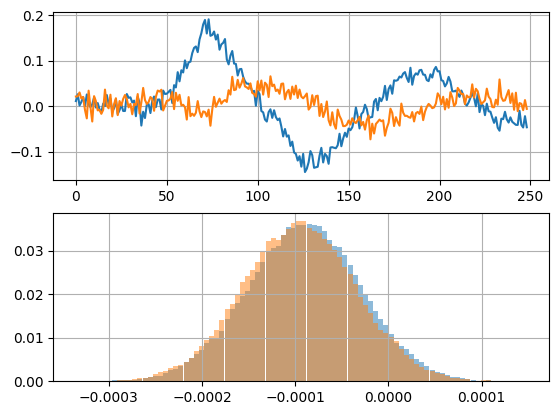

In [233]:
fig = plt.figure()
grid_0 = fig.add_gridspec(2, 2)
ax_0 = fig.add_subplot()
plot_params(ax[0], **params)
plot_hist(ax[1], **params)
plt.show()

In [234]:
N_optimize = 5000

optimizer = optax.adam(1e-3)
optimizer_state = optimizer.init(params)
costs = []

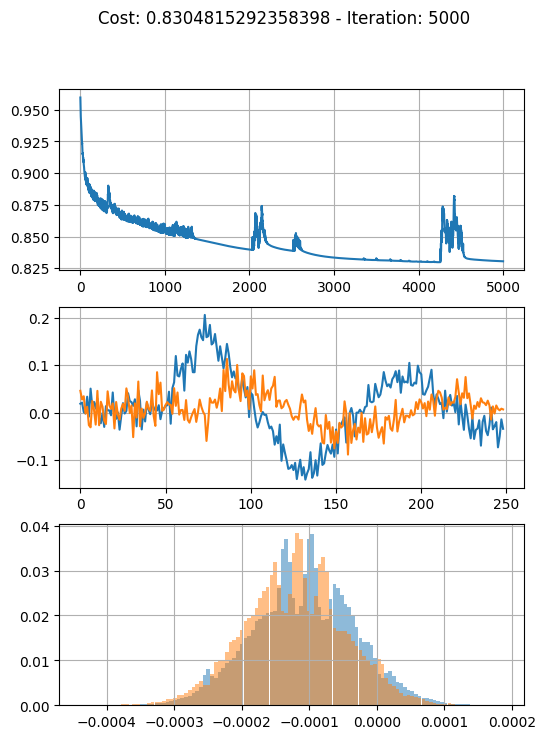

100%|███████████████████████████████████████████████████████████| 5000/5000 [00:52<00:00, 95.29it/s]


In [235]:
for ind in tqdm(range(N_optimize)):
    cost, cost_grad = jax.value_and_grad(compute_overlap)(params)
    updates, optimizer_state = optimizer.update(cost_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    costs.append(cost)

    if (ind+1)%100 == 0:
        clear_output(wait=True)
        fig, ax = plt.subplots(3, figsize=(6, 8))
        fig.suptitle(f'Cost: {cost} - Iteration: {ind+1}')
        ax[0].plot(costs)
        ax[0].grid()
        plot_params(ax[1], **params)
        plot_hist(ax[2], **params)
        plt.show()

# Optimize on error

In [163]:
weighted = weight_points(weights_diff, datas)
iqr_real = jnp.diff(jnp.percentile(weighted.real, jnp.array([25 ,75])))[0]
iqr_imag = jnp.diff(jnp.percentile(weighted.imag, jnp.array([25 ,75])))[0]
h_real = 2*iqr_real*(len(weighted)**(-1/3))
h_imag = 2*iqr_imag*(len(weighted)**(-1/3))
h = jnp.sqrt(h_real**2 + h_imag**2)
print(h)

1.0787187e-05


In [196]:
def compute_error(params) -> float:
    abs_weights, phase_weights, threshold = params["abs_weights"], params["phase_weights"], params['threshold']
    w = compute_weights(abs_weights, phase_weights)
    weighted = weight_points(w, datas).real
    error_left = jnp.sum(jnp.where(weighted[:, 1]<threshold, 1, 0))
    error_right = jnp.sum(jnp.where(weighted[:, 0]>threshold, 1, 0))    
    return (error_left+error_right)/2

In [197]:
def plot_hist(ax, abs_weights, phase_weights, threshold):
    w = abs_weights*jnp.exp(1j*phase_weights)
    weighted = weight_points(w, datas).real
    vmin, vmax = jnp.min(weighted), jnp.max(weighted)
    xs = jnp.linspace(vmin, vmax, int((vmax-vmin)/h))
    hist = jnp.sum(gaussian(weighted[:, :, None], h, xs[None, None, :]), axis=0)
    hist = hist/jnp.sum(hist, axis=1)[:, None]
    ax.bar(xs, hist[0], h, alpha = 0.5)
    ax.bar(xs, hist[1], h, alpha = 0.5)
    ax.axvline(threshold, color='r')
    ax.grid()

In [198]:
def plot_params(ax, abs_weights, phase_weights, threshold):
    w = compute_weights(abs_weights, phase_weights)
    ax.plot(w.real)
    ax.plot(w.imag)
    ax.grid()

In [199]:
params = {"abs_weights": jnp.abs(weights_diff), "phase_weights": jnp.angle(weights_diff), "threshold": -1e-4}
compute_error(params)
jax.value_and_grad(compute_error)(params)

(Array(10380., dtype=float32),
 {'abs_weights': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0

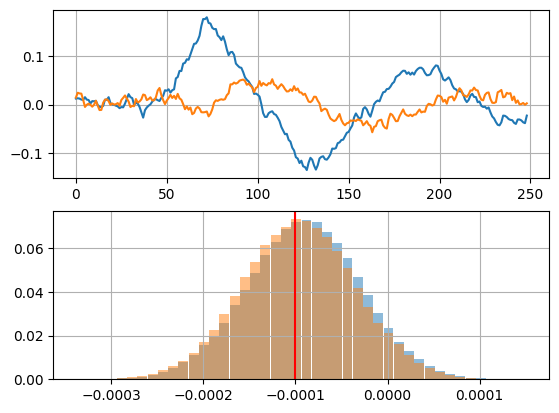

In [49]:
fig, ax = plt.subplots(2)
plot_params(ax[0], **params)
plot_hist(ax[1], **params)
plt.show()

In [50]:
N_optimize = 5000

optimizer = optax.adam(1e-3)
optimizer_state = optimizer.init(params)
costs = []

In [51]:
for ind in tqdm(range(N_optimize)):
    cost, cost_grad = jax.value_and_grad(compute_error)(params)
    cost_grad = {k: jnp.clip(v) for k, v in cost_grad.items()}
    updates, optimizer_state = optimizer.update(cost_grad, optimizer_state)
    params = optax.apply_updates(params, updates)
    costs.append(cost)

    if (ind+1)%100 == 0:
        clear_output(wait=True)
        fig, ax = plt.subplots(3, figsize=(6, 8))
        fig.suptitle(f'Cost: {cost} - Iteration: {ind+1}')
        ax[0].plot(costs)
        ax[0].grid()
        plot_params(ax[1], **params)
        plot_hist(ax[2], **params)
        plt.show()

  0%|                                                              | 2/5000 [00:00<16:45,  4.97it/s]


ValueError: cannot convert float NaN to integer